## Hessian-Based Filtering (Paper Implementation)

## Implementation methods ARCADE 2D

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from scipy.ndimage import convolve

def eig2image(Dxx, Dxy, Dyy):
    """
    Compute ordered eigenvalues (λ1 small-mag, λ2 large-mag) 
    and eigenvector for λ1 of the 2x2 Hessian.
    """
    # Discriminant Δ
    tmp = np.sqrt((Dxx - Dyy)**2 + 4 * Dxy**2)

    # Build & normalize v2
    v2x = 2 * Dxy
    v2y = Dyy - Dxx + tmp
    mag2 = np.hypot(v2x, v2y)
    nz = mag2 > 0
    v2x[nz] /= mag2[nz]
    v2y[nz] /= mag2[nz]

    # v1 orthogonal to v2
    v1x = -v2y
    v1y =  v2x

    # Raw eigenvalues μ1, μ2
    mu1 = 0.5 * (Dxx + Dyy + tmp)
    mu2 = 0.5 * (Dxx + Dyy - tmp)

    # Order by absolute value → λ1 ≤ λ2
    swap = np.abs(mu1) > np.abs(mu2)
    lambda1 = mu1.copy()
    lambda1[swap] = mu2[swap]
    lambda2 = mu2.copy()
    lambda2[swap] = mu1[swap]

    # Align v1 with λ1
    vx = v1x.copy()
    vy = v1y.copy()
    vx[swap] = v2x[swap]
    vy[swap] = v2y[swap]

    return lambda1, lambda2, vx, vy


def Hessian2D(I, sigma=1):
    """Compute I * (Gaussian 2nd-derivative kernels) = (Dxx,Dxy,Dyy)."""
    r = int(np.ceil(3 * sigma))
    x = np.arange(-r, r+1)
    X, Y = np.meshgrid(x, x, indexing='ij')
    norm = 1/(2*np.pi*sigma**4)
    Gxx = norm*((X**2/sigma**2)-1)*np.exp(-(X**2+Y**2)/(2*sigma**2))
    Gxy = norm*(X*Y/sigma**2)*np.exp(-(X**2+Y**2)/(2*sigma**2))
    Gyy = Gxx.T
    return (convolve(I, Gxx, mode='constant'),
            convolve(I, Gxy, mode='constant'),
            convolve(I, Gyy, mode='constant'))


def FrangiFilter2D(I,
                   FrangiScaleRange=np.array([1,10]),
                   FrangiScaleRatio=2,
                   FrangiBetaOne=0.8,
                   FrangiBetaTwo=5,
                   BlackWhite=True):
    """
    Your working vesselness filter—now with λ1,λ2 in paper order.
    """
    sigmas = np.arange(FrangiScaleRange[0],
                       FrangiScaleRange[1] + 1,
                       FrangiScaleRatio)
    beta = 2 * FrangiBetaOne**2   # = 2 ε²
    c    = 2 * FrangiBetaTwo**2   # = 2 c²

    ALLf = np.zeros((I.shape[0], I.shape[1], len(sigmas)))
    ALLa = np.zeros_like(ALLf)

    for i, sigma in enumerate(sigmas):
        # Hessian & normalization
        Dxx, Dxy, Dyy = Hessian2D(I, sigma)
        Dxx *= sigma**2; Dxy *= sigma**2; Dyy *= sigma**2

        # *** PAPER‐ORDER unpack (λ1 small, λ2 large) ***
        lambda1, lambda2, vx, vy = eig2image(Dxx, Dxy, Dyy)

        # Eccentricity & structureness (Eqs. 2–3)
        RB = (lambda1 / (lambda2 + 1e-12))**2
        S2 = lambda1**2 + lambda2**2

        V = np.exp(-RB/beta) * (1 - np.exp(-S2/c))

        # *** PAPER‐ORDER sign‐test (bright ridges: λ2<0) ***
        if BlackWhite:
            V[lambda2 < 0] = 0
        else:
            V[lambda2 > 0] = 0

        ALLf[..., i] = V
        ALLa[..., i] = np.arctan2(vx, vy)

    vesselness = np.max(ALLf, axis=2)
    whatScale  = np.argmax(ALLf, axis=2) + 1
    direction  = np.take_along_axis(ALLa,
                    np.argmax(ALLf, axis=2)[..., None],
                    axis=2)[..., 0]

    return vesselness, whatScale, direction


### Loop for testing parameters

In [5]:
# ——— Main (unchanged) ———
image_path = '../../nnNet_training/Raw_data/Dataset_train_val/imagesTr/sten_0000_0000.png'
I = imread(image_path, as_gray=True).astype(np.float64)
if I.max() > 1: I /= 255.0

In [ ]:
# 1) Define your micro‐grid around the starting point
epsilons = [0.01, 0.02, 0.05, 0.10, 0.20, 0.40, 0.80, 1.60]
gammas   = [0.01, 0.02, 0.05, 0.10, 0.20, 0.40, 0.80, 1.60]

# 2) Compute all vesselness maps
results = []
for eps in epsilons:
    for gam in gammas:
        vess, _, _ = FrangiFilter2D(
            I,
            FrangiScaleRange=np.array([1,16]),
            FrangiScaleRatio=1.0,
            FrangiBetaOne=eps,
            FrangiBetaTwo=gam,
            BlackWhite=True
        )
        results.append((eps, gam, vess))

# 3) Find global vmin/vmax (e.g. 1st and 99th percentile)
all_maps = np.stack([v for _,_,v in results], axis=0)
vmin = np.percentile(all_maps, 1)
vmax = np.percentile(all_maps, 99)

# 4) Plot them in a grid with fixed contrast
nrows = len(epsilons)
ncols = len(gammas)
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))

for (eps, gam, vess) in results:
    i = epsilons.index(eps)
    j = gammas.index(gam)
    ax = axes[i, j] if nrows>1 else axes[j]
    ax.imshow(vess, cmap='gray', vmin=vmin, vmax=vmax)
    ax.set_title(f"ε={eps}, γ={gam}")
    ax.axis('off')

plt.tight_layout()
plt.show()

### SIngle Example

In [4]:
vesselness, scale_map, orientation = FrangiFilter2D(
    I,
    FrangiScaleRange=np.array([1,16]),   # skip the noisiest σ=1
    FrangiScaleRatio=1.0,
    FrangiBetaOne=1.5,                   # re-introduce a bit more ratio penalty
    FrangiBetaTwo=0.044,                   # tighten up the S² boost
    BlackWhite=True
)

NameError: name 'I' is not defined

### GPU example

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from scipy.ndimage import gaussian_filter  # only for kernel comparison, not used in GPU version

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def eig2image_torch(Dxx, Dxy, Dyy):
    """
    Compute ordered eigenvalues (λ1 small‐mag, λ2 large‐mag) 
    and eigenvector for λ1 of the 2×2 Hessian, with torch tensors.
    """
    tmp = torch.sqrt((Dxx - Dyy)**2 + 4 * Dxy**2)
    # raw eigenvalues
    mu1 = 0.5 * (Dxx + Dyy + tmp)
    mu2 = 0.5 * (Dxx + Dyy - tmp)
    # order by absolute value
    swap = (mu1.abs() > mu2.abs())
    lambda1 = mu1.clone()
    lambda2 = mu2.clone()
    lambda1[swap] = mu2[swap]
    lambda2[swap] = mu1[swap]
    # build & normalize v2
    v2x = 2 * Dxy
    v2y = Dyy - Dxx + tmp
    mag2 = torch.hypot(v2x, v2y)
    nz = mag2 > 0
    v2x[nz] /= mag2[nz]
    v2y[nz] /= mag2[nz]
    # v1 orthogonal to v2
    v1x = -v2y
    v1y =  v2x
    # align v1 with lambda1
    vx = v1x.clone()
    vy = v1y.clone()
    vx[swap] = v2x[swap]
    vy[swap] = v2y[swap]
    return lambda1, lambda2, vx, vy

def FrangiFilter2D_gpu(I, FrangiScaleRange=np.array([1,10]), FrangiScaleRatio=2,
                       FrangiBetaOne=0.8, FrangiBetaTwo=5, BlackWhite=True):
    """
    GPU-accelerated Frangi vesselness filter (torch) according to the paper. 
    """
    # Move image to GPU
    I_t = torch.from_numpy(I.astype(np.float32)).unsqueeze(0).unsqueeze(0).to(device)
    H, W = I.shape
    sigmas = np.arange(FrangiScaleRange[0], FrangiScaleRange[1] + 1, FrangiScaleRatio)
    beta = 2 * FrangiBetaOne**2
    c    = 2 * FrangiBetaTwo**2

    ALLf = torch.zeros((len(sigmas), H, W), device=device)
    ALLa = torch.zeros_like(ALLf)

    for i, sigma in enumerate(sigmas):
        # Build Gaussian second-derivative kernels on CPU, then move to GPU
        r = int(np.ceil(3 * sigma))
        x = np.arange(-r, r+1)
        X, Y = np.meshgrid(x, x, indexing='ij')
        norm = 1 / (2 * np.pi * sigma**4)
        Gxx = norm * ((X**2 / sigma**2) - 1) * np.exp(-(X**2 + Y**2) / (2*sigma**2))
        Gxy = norm * (X * Y / sigma**2)       * np.exp(-(X**2 + Y**2) / (2*sigma**2))
        Gyy = Gxx.T
        # Convert to torch kernels [out_ch, in_ch, kh, kw] = [1,1,kh,kw]
        kernel_xx = torch.from_numpy(Gxx.astype(np.float32))[None,None].to(device)
        kernel_xy = torch.from_numpy(Gxy.astype(np.float32))[None,None].to(device)
        kernel_yy = torch.from_numpy(Gyy.astype(np.float32))[None,None].to(device)
        pad = r

        # Convolve on GPU
        Dxx = F.conv2d(I_t, kernel_xx, padding=pad)
        Dxy = F.conv2d(I_t, kernel_xy, padding=pad)
        Dyy = F.conv2d(I_t, kernel_yy, padding=pad)
        # Normalize by sigma^2
        Dxx *= sigma**2; Dxy *= sigma**2; Dyy *= sigma**2

        # Eigen-decomposition & vesselness
        l1, l2, vx, vy = eig2image_torch(Dxx[0,0], Dxy[0,0], Dyy[0,0])
        RB = (l2 / (l1 + 1e-12))**2
        S2 = l1**2 + l2**2
        V  = torch.exp(-RB/beta) * (1 - torch.exp(-S2/c))

        # Sign-test (bright ridges: paper λ2<0)
        if BlackWhite:
            V[l1 < 0] = 0
        else:
            V[l1 > 0] = 0

        ALLf[i] = V
        ALLa[i] = torch.atan2(vx, vy)

    # Aggregate
    vesselness, idx = torch.max(ALLf, dim=0)
    whatScale = idx.to(torch.float32) + sigmas[0]
    orientation = ALLa.gather(0, idx[None,...])[0]

    # Move to CPU numpy
    return vesselness.cpu().numpy(), whatScale.cpu().numpy(), orientation.cpu().numpy()

# ——— Usage ———
image_path = '../../nnNet_training/Raw_data/Dataset_train_val/imagesTr/sten_0000_0000.png'
I = imread(image_path, as_gray=True).astype(np.float64)
if I.max()>1: I /= 255.0

# Hyper‐parameter grids
epsilons     = [0.8, 1.0, 1.2, 1.4]   # FrangiBetaOne 
gammas       = [2.0, 3.0, 5.0, 8.0]    # FrangiBetaTwo
scale_steps  = [1.0]         # FrangiScaleRatio

# Prepare figure: rows=epsilons, cols=gammas×scale_steps
nrows = len(epsilons)
ncols = len(gammas) * len(scale_steps)
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))

for i, eps in enumerate(epsilons):
    for j, gam in enumerate(gammas):
        for k, step in enumerate(scale_steps):
            col = j*len(scale_steps) + k
            ax = axes[i, col] if nrows>1 else axes[col]

            # Run GPU‐Frangi with this combo
            vess, _, _ = FrangiFilter2D_gpu(
                I,
                FrangiScaleRange=np.array([1,16]),
                FrangiScaleRatio=step,
                FrangiBetaOne=eps,
                FrangiBetaTwo=gam,
                BlackWhite=True
            )

            # Normalize for display
            vp = (vess - vess.min()) / (vess.max() - vess.min())

            # Plot
            ax.imshow(vp, cmap='gray')
            ax.set_title(f"ε={eps}, γ={gam}, step={step}")
            ax.axis('off')

plt.tight_layout()
plt.show()

## FRANGI ALREADY IMPLEMENTED

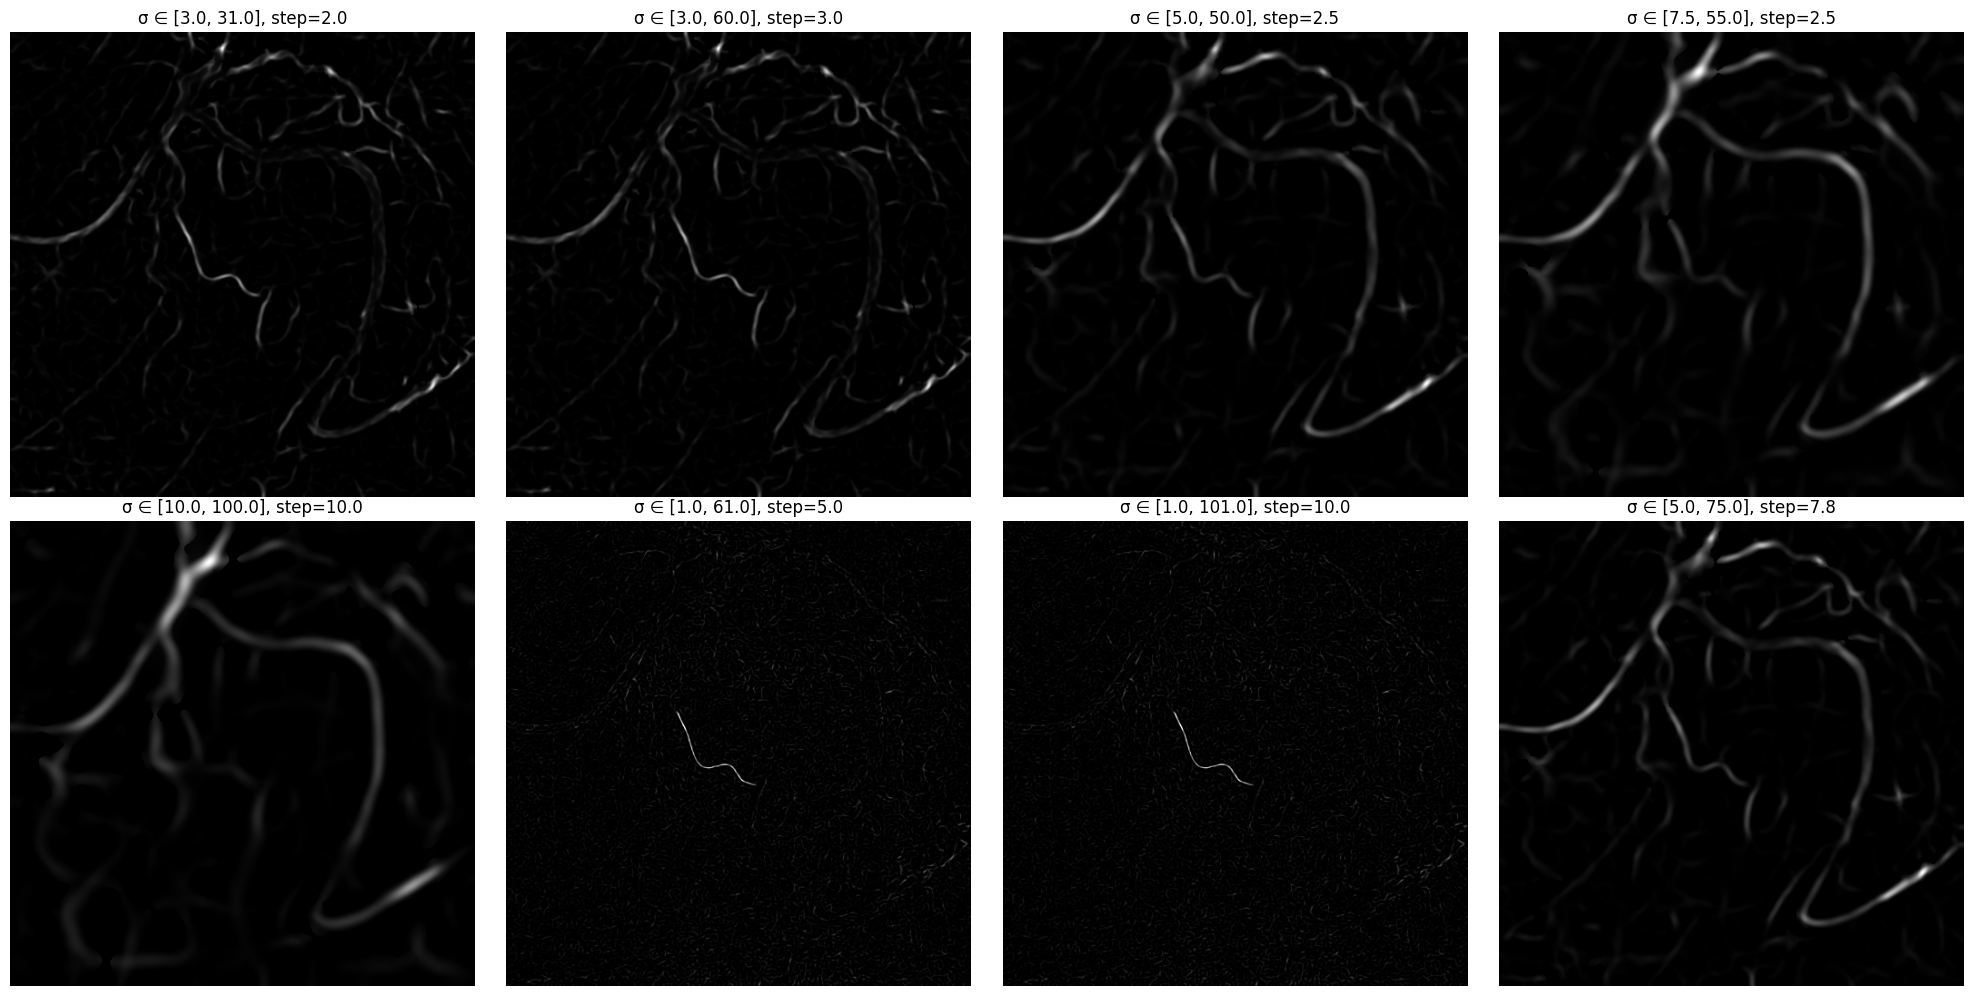

In [69]:
import numpy as np
from skimage.filters import frangi

sigma_sets = [
    np.arange(3, 32, 2),
    np.arange(3, 63, 3),
    np.arange(5, 52.5, 2.5),
    np.arange(7.5, 57.5, 2.5),
    np.arange(10, 110, 10),
    np.arange(1, 65, 5),
    np.arange(1, 110, 10),
    np.linspace(5, 75, 10)
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for ax, sigmas in zip(axes, sigma_sets):
    v = frangi(
        I.astype(float),
        sigmas=sigmas,
        alpha=1.0,
        beta=1.0,
        gamma=0.1,
        black_ridges=True,
        mode='reflect'
    )
    ax.imshow(v, cmap='gray')
    ax.set_title(f"σ ∈ [{sigmas[0]:.1f}, {sigmas[-1]:.1f}], step={sigmas[1]-sigmas[0]:.1f}")
    ax.axis('off')

plt.tight_layout()
plt.show()